#**Connect To your Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Note**
Upload your data in a folder called 'pipline'

#**Getting Ground Truth Pipe Orientations Using Moments** 

In [2]:
import glob
import os
import matplotlib.pylab as plt
import cv2
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Add your Dataset in this manner 
path = "gdrive/MyDrive/pipeline/*.jpg"

image_pathes = glob.glob(path)

def find_orientation(im):
    im_yellow = im[:, :, 1] - im[:, :, 0]
    _, im_thresh = cv2.threshold(im_yellow, 100, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_area = max_index = 0
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) > max_area:
            max_area = cv2.contourArea(contours[i])
            max_index = i
    if max_area < 3500:
        return (False, 0, 0,0 , 0)
    im_contour = cv2.drawContours(np.zeros(im.shape[0:2]), contours, max_index, 1, -1)
    moments = cv2.moments(im_contour)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    covar = np.zeros((2, 2))
    covar[0, 0] = moments['mu20'] / moments['m00']
    covar[1, 1] = moments['mu02'] / moments['m00']
    covar[1, 0] = covar[0, 1] = moments['mu11'] / moments['m00']
    _, eigval, eigvec = cv2.eigen(covar)
    tan_theta = eigvec[0, 1]/ eigvec[0, 0]
    sign = np.sign(tan_theta)
    return (True, tan_theta, sign, cx, cy)

all_images = np.zeros((len(image_pathes),) + cv2.imread(image_pathes[0]).shape,dtype='uint8')
predections = np.zeros((len(image_pathes),) + (4,), dtype='float64')

for i in range(len(image_pathes)):
    all_images[i,:,:,:] = cv2.imread(image_pathes[i])

to_del = []
for i in range(len(image_pathes)):
    success, tan_theta, sign, cx, cy = find_orientation(all_images[i,:,:,:])
    predections[i,:] = [tan_theta, sign, cx, cy]
    if not success:
        to_del.append(i)
        
        
all_images = np.delete(all_images, np.array(to_del), axis=0)
predictions = np.delete(predections, np.array(to_del), axis=0)

np.save('pipeline_images.npy', all_images)
np.save('pipeline_predections.npy', predections)

cv2.destroyAllWindows()

#**Shuffle Functions**
To shuffle our data 

In [3]:

# fonction that assures two arrays are shuffled in the same manner 
def shuffle_in_unison(a, b):
    # make sure the vectors have the same length 
    assert len(a) == len(b)
    # random shuffle 
    p = np.random.permutation(len(a))
    # return shuffled array 
    return a[p], b[p]

# fonction that assures three arrays are shuffled in the same manner (four the hybrid model)
def shuffle_in_unison_2(a, b, c):
    # make sure the vectors have the same length 
    assert len(a) == len(b) == len(c)
    # random shuffle 
    p = np.random.permutation(len(a))
    # return shuffled array 
    return a[p], b[p], c[p]

#**Preparing orientations Data**
we assigned orientation (tangante value) above 5 to be five so it can stay a linear problem

In [39]:
# save images in array
x_data = all_images
# extract orientations from predictions array 
orientations = predictions[:, 0].reshape(-1, 1)

# make orientation absolute  
orientations = np.abs(orientations)

# orientation bigger than 5 make them 5 (to stay in linear a linear problem)
orientations[orientations > 5] = 5


#**Shuffling Orientation Data**

In [46]:
# shuffle data [images and their orientations]
x_data_shuffled, y_data_shuffled = shuffle_in_unison(x_data, orientations)

# split data images by 2 [train and test] 
Xtrain, Xtest = np.split(x_data_shuffled, 2)
# split data labels by 2 [train and test]
Ytrain_orientation, Ytest_orientation = np.split(y_data_shuffled, 2)

#**Defining Orientaion Model**
Based on **VGG16** model (but a little bit modified to) 

In [47]:

#input_shape = (4, 228, 308, 3)
def Orientation_model():
    
    input_layer = keras.layers.Input((228,308,3))
    y = tf.keras.layers.Rescaling(1./255)(input_layer)
    y = tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y =  tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y =  tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(128, 3, activation='relu')(y)
    y = tf.keras.layers.Conv2D(128, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(512, 3, activation='relu')(y)
    y = tf.keras.layers.Conv2D(512, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(256, 3, activation='relu')(y)
    y = tf.keras.layers.Conv2D(256, 3, activation='relu')(y)
    y = tf.keras.layers.Conv2D(256, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y =  tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu')(y)
    orientation_output = tf.keras.layers.Dense(1, name = 'orientation', activation=lambda x: x)(y)
    
    model = tf.keras.Model(inputs=input_layer,outputs=orientation_output)
    
    return model 
    

model_rotation = Orientation_model()

model_rotation.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                        loss=tf.losses.MSE,
                        metrics=['mae'])


#**Training orientation model with the Dataset**

In [48]:
# batch_size 
batch_size  = 32
# number of epoch 
epochs      =  50

# store model history and fit the model to our data 
history = model_rotation.fit(  Xtrain, Ytrain_orientation,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (Xtest, Ytest_orientation))

history_plot = history.history

Epoch 1/50
18/18 [==============================] - 12s 610ms/step - loss: 13.6311 - mae: 3.3093 - val_loss: 8.3817 - val_mae: 2.8067
Epoch 2/50
18/18 [==============================] - 10s 587ms/step - loss: 5.1142 - mae: 2.0175 - val_loss: 2.0381 - val_mae: 1.1544
Epoch 3/50
18/18 [==============================] - 10s 586ms/step - loss: 2.3805 - mae: 1.0523 - val_loss: 1.9588 - val_mae: 0.8901
Epoch 4/50
18/18 [==============================] - 10s 586ms/step - loss: 2.2266 - mae: 1.0557 - val_loss: 1.9580 - val_mae: 1.0260
Epoch 5/50
18/18 [==============================] - 10s 586ms/step - loss: 2.2417 - mae: 1.1329 - val_loss: 1.9785 - val_mae: 1.0823
Epoch 6/50
18/18 [==============================] - 10s 588ms/step - loss: 2.2686 - mae: 1.0835 - val_loss: 2.2678 - val_mae: 1.3551
Epoch 7/50
18/18 [==============================] - 10s 588ms/step - loss: 2.3261 - mae: 1.0956 - val_loss: 1.9596 - val_mae: 0.8366
Epoch 8/50
18/18 [==============================] - 10s 590ms/step -

In [49]:
# test our model 
score_orientation = model_rotation.evaluate(Xtest, Ytest_orientation, verbose=0)

print(f'Test loss     : {score_orientation[0]:4.4f}')
print(f'Test MAE : {score_orientation[1]:4.4f}')


Test loss     : 0.1056
Test MAE : 0.2121


#**Plotting model History**

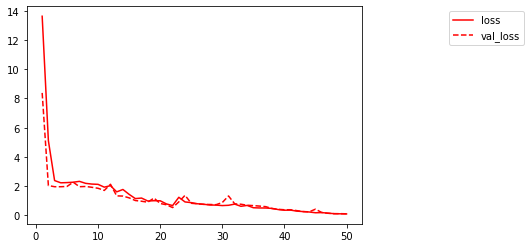

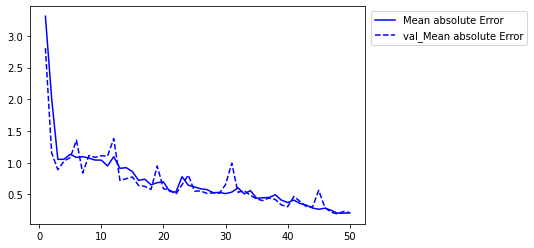

In [50]:
# show results 

plt.plot(np.arange(1, epochs + 1), np.array(history_plot['loss']).T, c = 'r', label = 'loss')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_loss']).T, '--', c = 'r', label = 'val_loss')
plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')

plt.show()

plt.plot(np.arange(1, epochs + 1), np.array(history_plot['mae']).T, c = 'b', label = 'Mean absolute Error')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_mae']).T,'--', c = 'b', label = 'val_Mean absolute Error')

plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')


#**Getting orientations' Sign**
**Note:** re assign negative value to zero so it can be a Binary classification problem 

In [30]:
#%% Sign data

# extract signs from prediction array 
signs = predictions[:, 1].reshape(-1, 1)

# signs that are -1 make them zero 
signs[signs == -1 ] = 0

# as type int 
signs = signs.astype(int)

#**Shuffling Signs Data**

In [31]:
#%% preparing sign data 


# shuffle data [images and their signs]
x_data_shuffled, y_data_shuffled = shuffle_in_unison(x_data, signs)

# split data images 800 for training
Xtrain = x_data[0 : 800]
Xtest = x_data[800: -1]

# split data labels by 800 for training
Ytrain = signs[0:800] 

Ytest = signs[800: -1]



#**Defining sign Model**


In [32]:
#%% sign model 
# creating the model 

model_sign = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255),
                                  tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                  tf.keras.layers.MaxPooling2D(),
                                  tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                  tf.keras.layers.MaxPooling2D(),
                                  tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(32, activation='relu'),
                                  tf.keras.layers.Dense(1, activation='sigmoid')])

model_sign.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.losses.binary_crossentropy,
                  metrics=['accuracy'])



#**Training the model**

In [33]:
# batch_size 
batch_size  = 8
# number of epoch 
epochs      =  40

# store model history and fit the model to our data 
history = model_sign.fit(  Xtrain, Ytrain,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (Xtest, Ytest))

# test our model 
score_sign = model_sign.evaluate(Xtest, Ytest, verbose=0)

# save the model 
model_sign.save("sign_model")




Epoch 1/40
100/100 [==============================] - 4s 35ms/step - loss: 0.7501 - accuracy: 0.6250 - val_loss: 0.6252 - val_accuracy: 0.6270
Epoch 2/40
100/100 [==============================] - 3s 33ms/step - loss: 0.6011 - accuracy: 0.6787 - val_loss: 0.5581 - val_accuracy: 0.6592
Epoch 3/40
100/100 [==============================] - 4s 36ms/step - loss: 0.4957 - accuracy: 0.7675 - val_loss: 0.4024 - val_accuracy: 0.8006
Epoch 4/40
100/100 [==============================] - 3s 32ms/step - loss: 0.3675 - accuracy: 0.8413 - val_loss: 0.4578 - val_accuracy: 0.7363
Epoch 5/40
100/100 [==============================] - 4s 35ms/step - loss: 0.2507 - accuracy: 0.8875 - val_loss: 0.2341 - val_accuracy: 0.8810
Epoch 6/40
100/100 [==============================] - 3s 33ms/step - loss: 0.2274 - accuracy: 0.9100 - val_loss: 0.1929 - val_accuracy: 0.9164
Epoch 7/40
100/100 [==============================] - 4s 35ms/step - loss: 0.2042 - accuracy: 0.9100 - val_loss: 0.1948 - val_accuracy: 0.9196

#**Evaluating on the Test set**

In [34]:
score_sign = model_sign.evaluate(Xtest, Ytest, verbose=0)

print(f'Test loss     : {score_sign[0]:4.4f}')
print(f'Test accuracy : {score_sign[1]:4.4f}')

Test loss     : 0.1611
Test accuracy : 0.9421


In [35]:
history_plot = history.history

#**Plot model History**

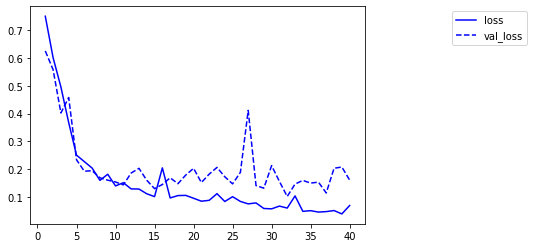

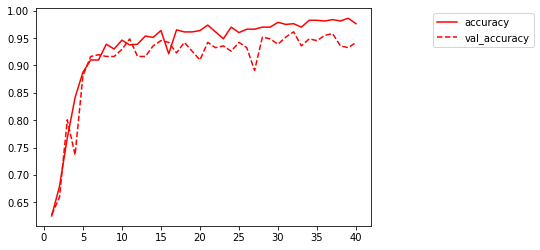

In [37]:
# show results 

plt.plot(np.arange(1, epochs + 1), np.array(history_plot['loss']).T, c = 'b', label = 'loss')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_loss']).T, '--', c = 'b', label = 'val_loss')
plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')

plt.show()

plt.plot(np.arange(1, epochs + 1), np.array(history_plot['accuracy']).T, c = 'r', label = 'accuracy')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_accuracy']).T,'--', c = 'r', label = 'val_accuracy')

plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')


#**Defining the Hybrid Model**
This model takes as an input the Image and outputs Orientation and sign at the same time 

In [22]:
def build_model():
    
    # Define model layers.
    # same as the above 
    input_layer = keras.layers.Input((228,308,3))
    x = tf.keras.layers.Rescaling(1./255)(input_layer)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x =  tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x =  tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x =  tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    orientation_output = tf.keras.layers.Dense(1, name = 'orientation', activation=lambda x: x)(x)

    y = tf.keras.layers.Rescaling(1./255)(input_layer)
    y = tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(32, activation='relu')(y)
    # output layer for sign with the name to apply a specific loss and metric 
    sign_output = tf.keras.layers.Dense(1, name = 'sign', activation='sigmoid')(y)
    # Define the model with the input layer 
    # and a list of output layers
    model = tf.keras.Model(inputs=input_layer,outputs=[orientation_output, sign_output])
    
    return model


#**Setting Loss and metric for each output layer**

In [ ]:
hybrid_model = build_model()

optimizer = tf.keras.optimizers.Adam(1e-3)

# set model metric and loss functions 
hybrid_model.compile(optimizer = optimizer, loss = {'orientation' : tf.losses.MSE, 'sign': tf.losses.binary_crossentropy}, 
                     metrics={'orientation':'mae',
                              'sign': 'accuracy'})


#**shuffling orientation and sign in the same manner**

In [23]:
#data Preparation for hybrid model 

# shuffle data [images and their orientations]
x_data_shuffled, y__orientation_data_shuffled, y__sign_shuffled = shuffle_in_unison_2(x_data, orientations, signs)

# split data images 800 for training
Xtrain = x_data_shuffled[0 : 800]
Xtest = x_data_shuffled[800: -1]

Ytrain_orientation = y__orientation_data_shuffled[0 : 800]
Ytest_orientation = y__orientation_data_shuffled[800: -1]


Ytrain_signs = y__sign_shuffled[0 : 800]
Ytest_signs = y__sign_shuffled[800: -1]

#**Training the Hybrid Model and assign each label to the correspond output layer**

In [24]:
# batch_size 
batch_size  = 16
# number of epoch 
epochs      =  50

# store model history and fit the model to our data 
history = hybrid_model.fit(  Xtrain, {"orientation": Ytrain_orientation, "sign": Ytrain_signs},
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (Xtest, {"orientation": Ytest_orientation, "sign": Ytest_signs}))

# test our model 
score_hybrid_model = hybrid_model.evaluate(Xtest, Ytest, verbose=0)

hybrid_model.save("hybrid_model")

Epoch 1/50
50/50 [==============================] - 16s 304ms/step - loss: 15.5962 - orientation_loss: 14.5008 - sign_loss: 1.0954 - orientation_mae: 3.0569 - sign_accuracy: 0.5688 - val_loss: 3.5845 - val_orientation_loss: 2.8930 - val_sign_loss: 0.6916 - val_orientation_mae: 1.6561 - val_sign_accuracy: 0.5916
Epoch 2/50
50/50 [==============================] - 15s 297ms/step - loss: 3.0035 - orientation_loss: 2.3140 - sign_loss: 0.6894 - orientation_mae: 1.1221 - sign_accuracy: 0.5825 - val_loss: 2.3066 - val_orientation_loss: 1.6196 - val_sign_loss: 0.6870 - val_orientation_mae: 0.8289 - val_sign_accuracy: 0.5916
Epoch 3/50
50/50 [==============================] - 15s 298ms/step - loss: 2.7032 - orientation_loss: 2.0171 - sign_loss: 0.6861 - orientation_mae: 0.9877 - sign_accuracy: 0.5825 - val_loss: 2.0711 - val_orientation_loss: 1.3873 - val_sign_loss: 0.6838 - val_orientation_mae: 0.9327 - val_sign_accuracy: 0.5916
Epoch 4/50
50/50 [==============================] - 15s 300ms/ste

In [25]:
history_plot = history.history

#**Plotting the model History**

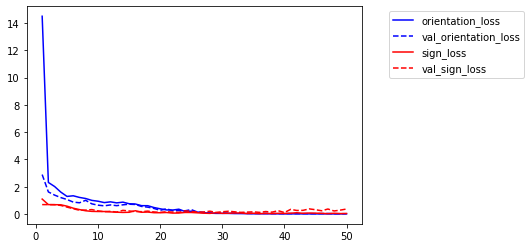

In [26]:
# show results 

plt.plot(np.arange(1, epochs + 1), np.array(history_plot['orientation_loss']).T, c = 'b', label = 'orientation_loss')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_orientation_loss']).T, '--', c = 'b', label = 'val_orientation_loss')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['sign_loss']).T, c = 'r', label = 'sign_loss')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_sign_loss']).T, '--', c = 'r', label = 'val_sign_loss')

plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')

plt.show()




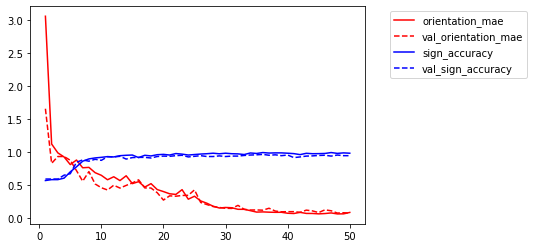

In [29]:
# show results 


plt.plot(np.arange(1, epochs + 1), np.array(history_plot['orientation_mae']).T, c = 'r', label = 'orientation_mae')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_orientation_mae']).T,'--', c = 'r', label = 'val_orientation_mae')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['sign_accuracy']).T, c = 'b', label = 'sign_accuracy')
plt.plot(np.arange(1, epochs + 1), np.array(history_plot['val_sign_accuracy']).T,'--', c = 'b', label = 'val_sign_accuracy')

plt.legend(bbox_to_anchor=(1.5, 1), loc = 'upper right')

plt.show()